In [232]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import pickle
import random 
from tqdm import tqdm
import seaborn as sns

# Set cut-off for number of trials to consider
cut = 1000
num_shuffles = 10000
bin_size = 20
def shuffle_plot_differences(lesi_av, cont_av_padded, cut,num_shuffles,bin_size,animals):

    # Initialize lists to store data
    new, group, cum_trials, animalid = [], [], [], []

    # Process each item in t_levels
    for index, item in enumerate(lesi_av + cont_av_padded):
        new += list(item[0:cut])  # Append the first 'cut' elements of the current item
        group += cut * ['lesion' if index < len(lesi_av) / 2 else 'control']  # Assign group
        animalid += [animals[index]] * cut  # Append animal ID
        cum_trials += list(np.linspace(1, cut, cut))  # Generate cumulative trial numbers

    # Create DataFrame with collected data
    df = pd.DataFrame({'CumTrials': cum_trials, 'Level': new, 'Group': group, 'ID': animalid})

    # Set seaborn color palette
    color_palette = [(0.24715576, 0.49918708, 0.57655991), (160/255, 11/255 , 11/255)]
    sns.set_palette(color_palette)


    # Define function to generate experimental group labels
    def generate_eg(list_size, prob, hue_order):
        return [hue_order[0] if random.random() < prob else hue_order[1] for _ in range(list_size)]



    # define a 10-trial window to bin the data
    XBIN = bin_size

    # Bin trial indices
    df["TrialIndexBinned"] = (df.CumTrials.values // XBIN) * XBIN + XBIN / 2

    # Group by 'ID', 'Group', 'TrialIndexBinned' and calculate mean
    df_bintr = df.groupby(['ID', 'Group', 'TrialIndexBinned']).mean().reset_index()
    df_bintr['Performance'] = df_bintr.Level

    hue_order = ['control', 'lesion']

    # Calculate performance difference between groups
    perdif_df = df_bintr[df_bintr.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
                df_bintr[df_bintr.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']

    # Select necessary columns
    df_colsel = df_bintr[['ID', 'Group', 'TrialIndexBinned', 'Performance']].copy()

    # Calculate probability for experimental group
    exp_gr = [df_colsel[df_colsel.ID == x].Group.unique()[0] for x in df_colsel.ID.unique()]
    cb_prob = sum([x == hue_order[0] for x in exp_gr]) / len(exp_gr)

    # Seed for reproducibility
    np.random.seed(124321)

    # Shuffle results
    shuff_res = []

    # Shuffle and compute performance differences
    NSH = num_shuffles
    for _ in tqdm(range(NSH)):
        exp_grs = generate_eg(len(exp_gr), cb_prob,hue_order)
        egs_dict = dict(zip(df_colsel.ID.unique(), exp_grs))
        df_colsel['egs'] = df_colsel.ID.map(egs_dict)
        diff = df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
        shuff_res.append(diff)

    shrdf = pd.concat(shuff_res)

    # Calculate real data performance difference
    real_data = df_colsel[df_colsel.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
                df_colsel[df_colsel.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
    real_data *= -1

    # Plot results
    pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
    neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

    plt.figure(figsize=(4, 7))
    plt.axhline(0, ls='dotted', alpha=0.4, color='k')
    plt.plot(real_data, color='#2D5460', label='observed data')
    plt.plot(pos_ci, linestyle='--', color='#252525', label='95% ci')
    plt.plot(neg_ci, linestyle='--', color='#252525')

    x = pos_ci.reset_index().TrialIndexBinned
    y1 = neg_ci.reset_index().Performance
    y2 = real_data.reset_index().Performance
    y3 = pos_ci.reset_index().Performance

    plt.fill_between(x, y1, y2, where=y2 <= y1, facecolor='#2D5460', alpha=.3, interpolate=True)
    plt.fill_between(x, y2, y3, where=y2 >= y3, facecolor='#2D5460', alpha=.3, interpolate=True)
    plt.ylabel('Performance difference (levels)')
    plt.xlabel('trial number')
    plt.legend(loc=(0.75, 0.05), frameon=False)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim((0, cut))


PATH = r"Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\data\hippocampus\\"

#to do:
 - save out these plots
 - save out these plots with a longer timescale (full learning curve?)
 - make plots for trials per day...


# first recreate the learning curve plots from the paper

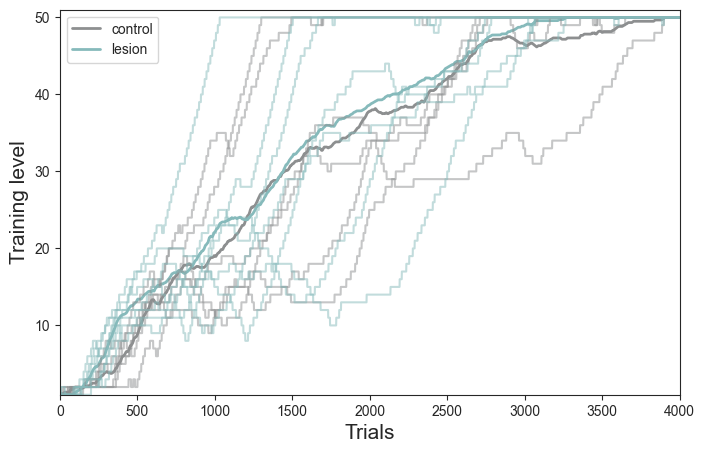

In [167]:
def parse_training_levels(training_levels):
    t_levels = []
    for row in training_levels:
        row = row.replace('nan', 'None')
        row = '[' + ', '.join(convert_float_string(x) for x in row.strip('[]').split(', ')) + ']'
        t_levels.append(literal_eval(row))
    return t_levels

def convert_float_string(s):
    try:
        # Attempt to convert scientific notation to a plain float string
        if 'e' in s.lower():
            value = float(s)
            return str(value)
        else:
            return s  # Return original string if not in scientific notation
    except ValueError:
        return s  # Return original string if not a valid float
    

def calculate_mean_std(t_levels, mask):
    trial_scores = conactinate_nth_items(np.array(t_levels)[mask])
    mean_curve = [np.mean(item) for item in trial_scores]
    std_curve = [np.std(item) for item in trial_scores]
    return mean_curve, std_curve

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def fill_between_mean_std(ax, mean_curve, std_curve, color,xlim):
    upper = np.array(mean_curve[:xlim]) + np.array(std_curve[:xlim])
    lower = np.array(mean_curve[:xlim]) - np.array(std_curve[:xlim])
    upper[upper > 50] = 50  # Ceiling effect cutoff
    ax.fill_between(range(len(upper)), lower, upper, alpha=0.2, edgecolor='None', facecolor=color, linewidth=1, linestyle='dashdot', antialiased=True)
    
def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)



# Get the current working directory
current_working_dir = r"C:\Users\Emmett Thompson\Documents\sequences_analyse_PPseq\revision_analysis\behavioural_reanalysis\\"



# Read CSV
pl_data = pd.read_csv(current_working_dir + 'hippocampus_learning_curves.csv')


# Extract data
categories = pl_data.catagory.values
animals = pl_data.animal.values
t_levels = parse_training_levels(pl_data.training_levels.values)

# Calculate mean and std for lesion and control groups
lesion_mask = categories == 'lesion'
lesion_MeanLearningCurve, lesion_std = calculate_mean_std(t_levels, lesion_mask)

control_mask = categories == 'control'
control_MeanLearningCurve, control_std = calculate_mean_std(t_levels, control_mask)

# Plot
%matplotlib inline
window = 10
xlim = 4000

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlim([0, xlim])
ax.set_ylim([1, 51])

ax.plot(convolve_movmean(control_MeanLearningCurve[:xlim], window), '-', color='#8D8F90', linewidth=2,label = 'control')
ax.plot(convolve_movmean(lesion_MeanLearningCurve[:xlim], window), '-', color='#86BABB', linewidth=2, label = 'lesion')

ax.set_xlabel('Trials', fontsize=15)
ax.set_ylabel('Training level', fontsize=15)

for index, bool in enumerate(control_mask):
    if bool:
        ax.plot(t_levels[index], color='#8D8F90', alpha=0.5)
for index, bool in enumerate(lesion_mask):
    if bool:
        ax.plot(t_levels[index], color='#86BABB', alpha=0.5)

# fill_between_mean_std(ax, lesion_MeanLearningCurve, lesion_std, '#BE575F',xlim)
# fill_between_mean_std(ax, control_MeanLearningCurve, control_std, dark_blue,xlim)

plt.legend(loc="upper left")

SaveFig('hlesion_tlevel_vs_trials_replot.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# load data and extract first 1000 trials from data

In [168]:
import glob

# Define groups and path
groups = ['control', 'lesions']
data_path = r'Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\data\hippocampus\\'

# Initialize empty DataFrame
data = pd.DataFrame({'group': [], 'animal': [], 'training_level_by_trial': [], 'trials_per_session': []})

all_paths= []
# Iterate over groups
for group in groups:
    # Build path
    path = f"{data_path}/{group}/*/AcrossSessions/AnalysisOutput/"
    preproc_path = f"{data_path}/{group}/*/Preprocessed/"
    
    # Find all paths matching the pattern
    paths = glob.glob(path)
    preproc_paths = glob.glob(preproc_path)
    
    all_paths+=preproc_paths
    # Iterate over paths
    for p in paths:
        # Extract animal name from path
        animal = p.split('\\')[-4]
        # Load training levels
        with open(p + 'Training_levels', 'rb') as fp:
            training_levels = pickle.load(fp)
        # Load trials per session
        with open(p + 'TrialsPerSessions', 'rb') as fp:
            trials_per_session = pickle.load(fp)
        
        # Append data to DataFrame
        new_data = pd.DataFrame([{'group': group, 'animal': animal, 'training_level_by_trial': training_levels, 'trials_per_session': trials_per_session}])
        data = pd.concat([data, new_data], ignore_index=True)
        
    


In [169]:

port1 = 2
port2 = 1
port3 = 6
port4 = 3
port5 = 7

AA_Port_transits = []
AA_Time_filter = []
AA_TransitionTypes_unfilt = []
AA_TransitionLatency_unfilt = []
AA_Start_Poke_out_time = []
AA_trial_id = []
AA_session_str = []

# Iterate through the rows of the DataFrame
for _, row in data.iterrows():
    
    all_sessions= os.listdir(all_paths[_])
    # Build path
    path = r" r'Z:\projects\Emmett\Documents\writeup\fig_hippocampus_lesions_Lcurve\data\hippocampus\\"
    # Find all paths matching the pattern
    sessions = glob.glob(path + "\\")

    # Find the start and end indices of the 4000-4500 trial range
    s = 0
    e = 1000
    
    # Initialize lists to store data
    Port_transits = []
    Time_filter = []
    TransitionTypes_unfilt = []
    TransitionLatency_unfilt = []
    Start_Poke_out_time = []
    trial_id = []
    session_str = []
            
    cum_sum = np.cumsum(row.trials_per_session)
    if cum_sum[-1] > e-1:
        first_session = 0
        last_session = np.where(cum_sum > e)[0][0]
        end_remainder = cum_sum[last_session] - e
        sessions = all_sessions[first_session:last_session+1]
        
        # set counter
        count = 0

        # Iterate over sessions
        for session in sessions:
            # Load data
            data_ = pd.read_csv(all_paths[_]+session + '\\PreProcessed_TransitionData.csv')

            # Select rows within the trial range
            if session == sessions[-1]:
                # Remove trials after end
                mask = data_.Trial_id.values <= data_.Trial_id.values[-1] - end_remainder
            else:
                # Keep all trials
                mask = np.ones(len(data_), dtype=bool)

            #track trials added
            count += len(data_[mask].Trial_id.unique())
            
        ######################################################################################################### Data extraction
            # Extract data from selected rows
            Time_filter += list(data_[mask].loc[:, '2s_Time_Filter_out_in'])
            TransitionTypes_unfilt += list(data_[mask].loc[:, 'Transition_type'])
            TransitionLatency_unfilt += list(data_[mask].loc[:, 'out_in_Latency'])
            Start_Poke_out_time += list(data_[mask].Start_Poke_out_time.values)
            trial_id += list(data_[mask].Trial_id.values)
            session_str += [session.split('\\')[-1].split('_')[0]] * len(data_[mask].Trial_id.values)


    AA_Start_Poke_out_time += [Start_Poke_out_time]
    AA_Time_filter += [Time_filter]
    AA_TransitionTypes_unfilt += [TransitionTypes_unfilt]
    AA_TransitionLatency_unfilt += [TransitionLatency_unfilt]
    AA_trial_id += [trial_id]
    AA_session_str += [session_str]
    print('should ~ 1000  :    ' +  str(count))


concat_data= []
for i in range(len(AA_TransitionTypes_unfilt)):
    new_row = [AA_session_str[i],AA_trial_id[i],AA_TransitionTypes_unfilt[i],AA_TransitionLatency_unfilt[i],AA_Time_filter[i],AA_Start_Poke_out_time[i]]
    concat_data.append(new_row)

df = pd.DataFrame(concat_data, columns = ['trials_0_1000_session','trials_0_1000_trial_id','trials_0_1000_transitions','trials_0_1000_latency','trials_0_1000_2s_timefilter','trials_0_1000_relativestarttime'])

data = pd.concat([data, df], axis=1)


should ~ 1000  :    999
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    999
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    1000
should ~ 1000  :    1000


# trials per day 

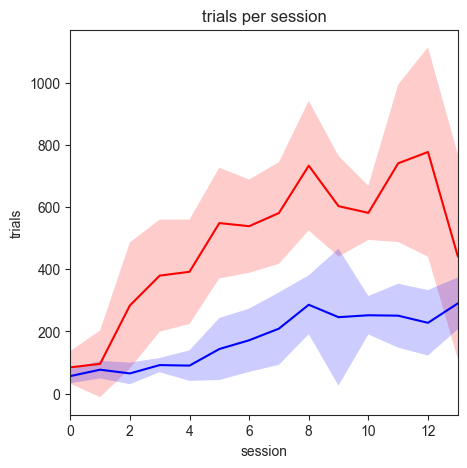

In [170]:
fig, ax = plt.subplots(1, 1,figsize=(5,5))
lesion_data = []
control_data = []
for _, row in data.iterrows():
    trials_per_sess = row.trials_per_session
    if row.group == 'lesions':
        col = 'red'
        lesion_data += [trials_per_sess]
    else:
        col = 'blue'
        control_data += [trials_per_sess]
    # ax.plot(trials_per_sess, c = col, alpha = 0.2)
    
l_mean = []
l_std = []
for item in conactinate_nth_items(lesion_data):
    l_mean+=[np.mean(item)]
    l_std +=[np.std(item)]
ax.plot(l_mean, c = 'red')

c_mean = []
c_std = []
for item in conactinate_nth_items(control_data):
    c_mean+=[np.mean(item)]
    c_std +=[np.std(item)]
ax.plot(c_mean, c = 'blue')

ax.fill_between(range(len(l_mean)), np.array(l_mean) - np.array(l_std), np.array(l_mean) + np.array(l_std), color='red', alpha=0.2, edgecolor='None', linewidth=1, linestyle='dashdot', antialiased=True)
ax.fill_between(range(len(c_mean)), np.array(c_mean) - np.array(c_std), np.array(c_mean) + np.array(c_std), color='blue', alpha=0.2, edgecolor='None', linewidth=1, linestyle='dashdot', antialiased=True)
    
ax.set_title('trials per session')
ax.set_xlabel('session')
ax.set_ylabel('trials')

ax.set_xlim(0,13)
# ax.set_ylim(0,1000)

SaveFig('hlesion_trials-per-session.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

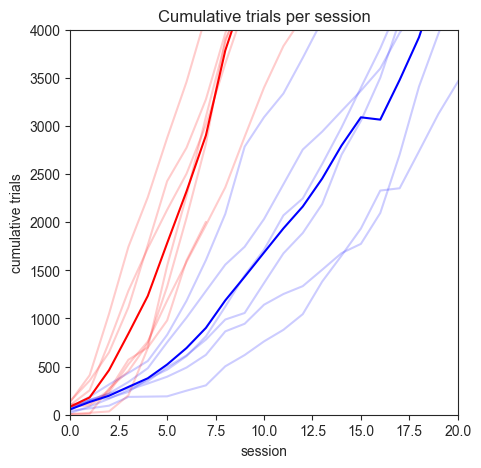

In [171]:
fig, ax = plt.subplots(1, 1,figsize=(5,5))

lesion_data = []
control_data = []
for _, row in data.iterrows():
    trials_per_sess = np.cumsum(row.trials_per_session)
    if row.group == 'lesions':
        col = 'red'
        lesion_data += [trials_per_sess]
    else:
        col = 'blue'
        control_data += [trials_per_sess]
    ax.plot(trials_per_sess, c = col, alpha = 0.2)
    
l_mean = []
for item in conactinate_nth_items(lesion_data):
    l_mean+=[np.mean(item)]
ax.plot(l_mean, c = 'red')

c_mean = []
for item in conactinate_nth_items(control_data):
    c_mean+=[np.mean(item)]
ax.plot(c_mean, c = 'blue')

ax.set_title('Cumulative trials per session')
ax.set_xlabel('session')
ax.set_ylabel('cumulative trials')

ax.set_xlim(0,20)
ax.set_ylim(0,4000)

SaveFig('hlesion_cum-trials-per-session.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

# error rate for first 1000 trials

one group has a p of less than 0.05 so is not normally distributed
ShapiroResult(statistic=0.7061099208210108, pvalue=0.007164923618571052)
ShapiroResult(statistic=0.8814047574427224, pvalue=0.23275696340199037)
so I use non paramteric comparisions test:
RanksumsResult(statistic=0.42857142857142855, pvalue=0.6682351417952492)


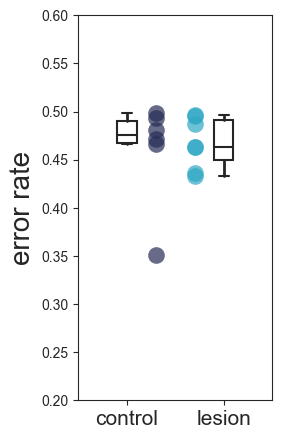

In [172]:
import seaborn as sns
import scipy

def determine_seq_scores_and_indicies(current_seq,variable_list):
    score = 0
    inds = []
    for item in variable_list:
        score= score + current_seq.count(item)
        current_inds = list(np.where(np.array(current_seq) == item)[0])
        inds = inds + current_inds
    return(score,inds)

error_rate_df = pd.DataFrame({'animal':[],'group':[],'correct_rate':[],'error_rate':[],'neural_rate':[]})

Correct = [21,16,63,37,72]
Error = [22,23,24,25,26,27,28,11,12,13,14,15,17,18,61,62,64,65,66,67,68,31,32,33,34,35,36,38,71,73,74,75,76,77,78]
Neutral = [41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,81,82,83,84,85,86,87,88]

for _, row in data.iterrows():
    #pull data from dfs:
    TransitionTypes_unfilt = np.array(row.trials_0_1000_transitions)
    TransitionLatency_unfilt = np.array(row.trials_0_1000_latency)

    # filter out transitions that are too slow (defined in preprocessing as 2s) and filter out transitions that are too fast (negative - this is probably a hardware error)   
    filter_mask = (np.array(TransitionLatency_unfilt) > 0) * (np.array(TransitionLatency_unfilt) < 2)
    TransitionTypes_Tfilt  = TransitionTypes_unfilt[filter_mask]
    TransitionLatency_Tfilt  = TransitionLatency_unfilt[filter_mask]

    c_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Correct)[0]/len(TransitionTypes_Tfilt)
    e_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Error)[0]/len(TransitionTypes_Tfilt)
    n_score = determine_seq_scores_and_indicies(list(TransitionTypes_Tfilt),Neutral)[0]/len(TransitionTypes_Tfilt)

    tempt_df = pd.DataFrame({'animal':[row.animal],'group':[row.group],'correct_rate':[c_score],'error_rate':[e_score],'neural_rate':[n_score]})
    error_rate_df = pd.concat([error_rate_df, tempt_df], ignore_index=True)
    


type_ = ['c_error_rate']*len(list(error_rate_df[error_rate_df.group == 'control'].error_rate.values)) + ['l_error_rate']*len(list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values))
scores = list(error_rate_df[error_rate_df.group == 'control'].error_rate.values) + list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values)
plt_df = pd.DataFrame({'group':type_,'score':scores})


fig, ax = plt.subplots(1, 1,figsize=(2.5,5))

color = '#262D56'
x = [0.3] *6
ax.plot(x, error_rate_df[error_rate_df.group == 'control'].error_rate.values,'o',markersize = 12, c = color, alpha = 0.7,markeredgewidth = 0)

color = '#2FA7C4'
x = [0.7] *7
ax.plot(x, error_rate_df[error_rate_df.group == 'lesions'].error_rate.values,'o',markersize = 12, c = color,alpha = 0.7,markeredgewidth = 0)


ax=sns.boxplot( y = 'score', x = 'group', data = plt_df, color = '#262D56', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_xticklabels(('control', 'lesion'), fontsize = 15)
ax.set_xlabel('',size = 20)
ax.set_ylabel('error rate',size = 20)

ax.set_ylim(0.2,0.6)

a = error_rate_df[error_rate_df.group == 'control'].error_rate.values
b = error_rate_df[error_rate_df.group == 'lesions'].error_rate.values

print('one group has a p of less than 0.05 so is not normally distributed')
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
print('so I use non paramteric comparisions test:')
print(scipy.stats.ranksums(a,b))

# SaveFig('hlesion_error-rate-1st-1000.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_error-rate-1st-1000.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


no difference in error rates over the first 1000 trials

# transition heatmaps - 1st 1000 trials

this needs to be normalised

0.5935323383084578
0.6748201438848921


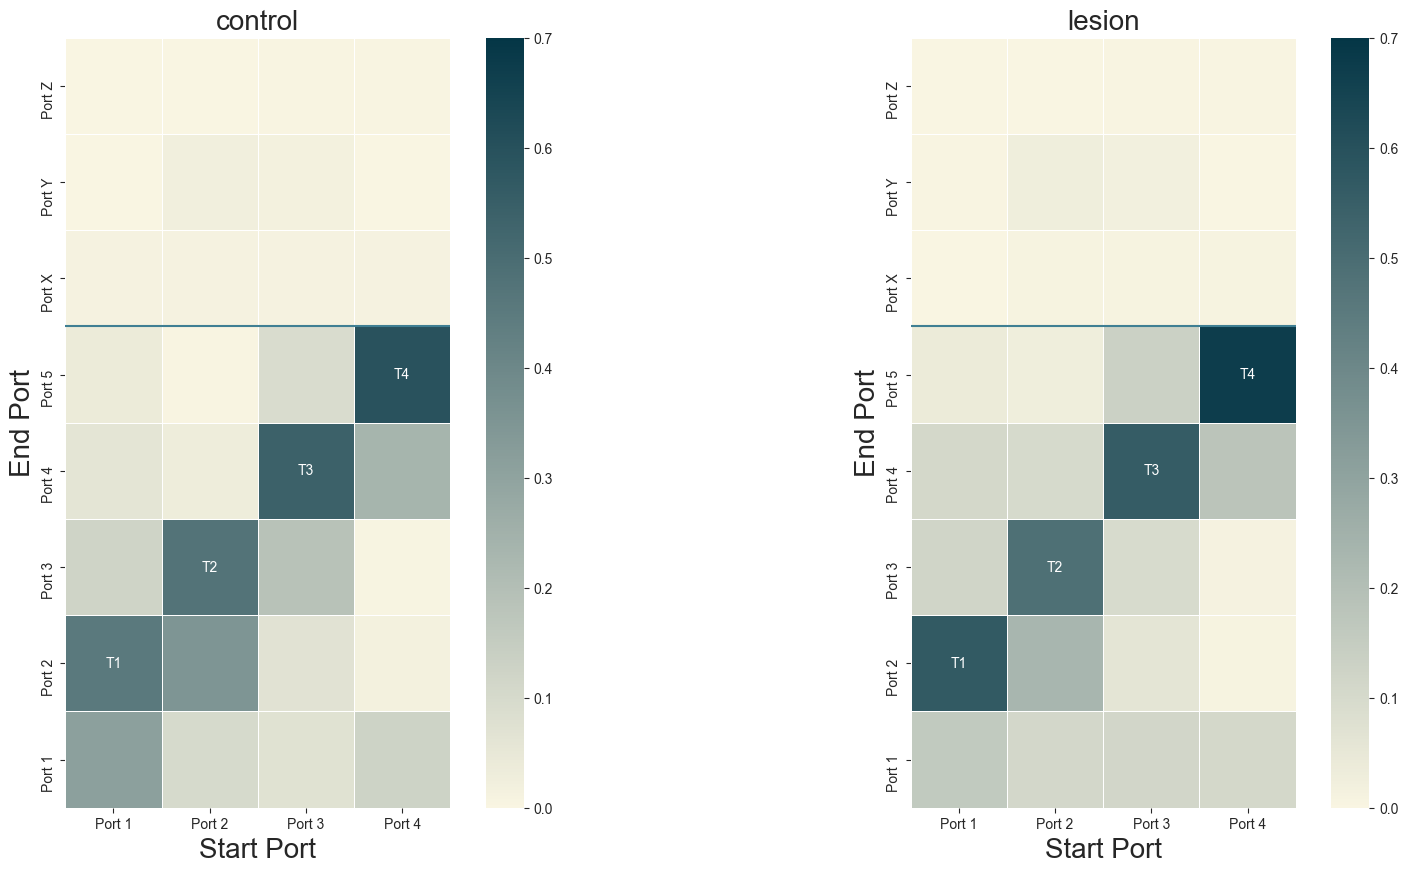

In [173]:
def CreateSequences_Time(Transition_types,Transition_times,transition_reference_time,Transition_filter_time):
    # reoder transitions into time releveant sequences  
    seq_index = 0
    TimeFiltered_ids = [[]]
    TimeFiltered_times = [[]]
    Reference_times = [[]]

    for ind, transit in enumerate (Transition_types):
        if Transition_times[ind] < Transition_filter_time and Transition_times[ind] > 0.03: # if less than filter time and more than lower bound filter time (0.05s):
            TimeFiltered_ids[seq_index] = TimeFiltered_ids[seq_index] + [transit]
            TimeFiltered_times[seq_index] = TimeFiltered_times[seq_index] + [Transition_times[ind]]
            Reference_times[seq_index] = Reference_times[seq_index] + [transition_reference_time[ind]]
            

        else:
            if TimeFiltered_ids[seq_index]: # if not empty 
                seq_index = seq_index + 1
                TimeFiltered_ids = TimeFiltered_ids + [[]]
                TimeFiltered_times = TimeFiltered_times +[[]] 
                Reference_times = Reference_times + [[]]
                TimeFiltered_ids[seq_index] = TimeFiltered_ids[seq_index] + [transit]
                TimeFiltered_times[seq_index] = TimeFiltered_times[seq_index] + [Transition_times[ind]]   
                Reference_times[seq_index] = Reference_times[seq_index] + [transition_reference_time[ind]]
    return TimeFiltered_ids,TimeFiltered_times,Reference_times

def determime_heatmapdata(var,port1,port2,port3,port4):
    # TransitionTypesIndex = np.array([11,12,13,14,15,16,17,18,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,61,62,63,64,65,66,67,68,71,72,73,74,75,76,77,78,81,82,83,84,85,86,87,88])
    port1_transits = []
    for i in range(((port1*8)-8),((port1*8)-8)+8):
        port1_transits = port1_transits + [var[i]]

    port2_transits = []
    for i in range(((port2*8)-8),((port2*8)-8)+8):
        port2_transits = port2_transits + [var[i]]

    port3_transits = []
    for i in range(((port3*8)-8),((port3*8)-8)+8):
        port3_transits = port3_transits + [var[i]]

    port4_transits = []
    for i in range(((port4*8)-8),((port4*8)-8)+8):
        port4_transits = port4_transits + [var[i]]

    port_transits = [port1_transits] + [port2_transits] + [port3_transits] + [port4_transits]

    return port_transits


def determineTransitionNumber(TimeFiltered_seqs):
    TransitionTypesIndex = np.array([11,12,13,14,15,16,17,18,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,61,62,63,64,65,66,67,68,71,72,73,74,75,76,77,78,81,82,83,84,85,86,87,88])
    trajects = []
    for inds, seqs in enumerate(TimeFiltered_seqs):
#         seqs = literal_eval(seqs) # convert back from weird df string conversion thing
        for ind, transits in enumerate(seqs):
#             if not str(transits)[0] == str(transits)[1]:
            trajects = np.append(trajects,transits)
    transition_number = []
    for transit_types in TransitionTypesIndex:
        temp = (np.where(trajects == float(transit_types)))
        transition_number.append(len(temp[0]))
    return transition_number

def reversedata(port_transits):

    reordered_port_transits = []
    for i in range(1,len(port_transits)+1):
        mylist = port_transits[-i]
        myorder = new_order
        mylist = [mylist[i] for i in myorder]
        newlist = []
        for item in mylist:
            newlist = newlist + [float(item)]
        reordered_port_transits = reordered_port_transits + [newlist]
    #restructure data to swap x and y axis:
    data = [[],[],[],[],[],[],[],[]]
    for ind in range(8):
        for index,item in enumerate(reordered_port_transits):
            data[ind] = data[ind] + [item[len(item)-1-ind]]
    for i in range(8):
        data[i].reverse()
    return data

def Find_Transition_times_sns(TransitionLatency_Tfilt,TransitionTypes_Tfilt,Transitions):
    transit_times = []
    transit_type = []
    for i,Transits in enumerate(Transitions):
        transit_times_temp = []
        for ind, transition_pair in enumerate(TransitionTypes_Tfilt):
            if transition_pair == Transits:
                transit_times_temp = transit_times_temp + [TransitionLatency_Tfilt[ind]]
                
        transit_times = transit_times + transit_times_temp
        transit_type = transit_type + len(transit_times_temp)*[i+1]
    return(transit_times,transit_type)

def find_max_in_nested_list(nested_list):
    max_val = float('-inf')
    
    for item in nested_list:
        if isinstance(item, list):
            # Recurse into the sublist
            max_val = max(max_val, find_max_in_nested_list(item))
        else:
            # Compare value directly
            max_val = max(max_val, item)
    
    return max_val


c_data = data[data.group == 'control']
l_data = data[data.group == 'lesions']
#reset index
l_data = l_data.reset_index()

c_AA_Port_transits = []
for i in range(len(c_data.animal.values)):
    TimeFiltered_ids,TimeFiltered_times,Reference_times = CreateSequences_Time(c_data.trials_0_1000_transitions[0],c_data.trials_0_1000_latency[0],c_data.trials_0_1000_relativestarttime[0],Transition_filter_time = 2.0)
    Port_transits = determime_heatmapdata(determineTransitionNumber(TimeFiltered_ids),port1,port2,port3,port4)
    c_AA_Port_transits = c_AA_Port_transits + [Port_transits]
l_AA_Port_transits = []
for i in range(len(l_data.animal.values)):
    TimeFiltered_ids,TimeFiltered_times,Reference_times = CreateSequences_Time(l_data.trials_0_1000_transitions[0],l_data.trials_0_1000_latency[0],l_data.trials_0_1000_relativestarttime[0],Transition_filter_time = 2.0)
    Port_transits = determime_heatmapdata(determineTransitionNumber(TimeFiltered_ids),port1,port2,port3,port4)
    l_AA_Port_transits = l_AA_Port_transits + [Port_transits]


from matplotlib.colors import LinearSegmentedColormap
color1 = '#F9F5E2'
color2 = '#043646'
# make a color map going from color1 to color2
cmap = LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

Port_transits = [c_AA_Port_transits,l_AA_Port_transits]

max_transitions_of_any = find_max_in_nested_list(Port_transits)

nrow = 1 
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 10))
for ind, ax in enumerate(fig.axes):

    AA_data= []
    for animal in Port_transits[ind]:
        flat_list = []
        for s_port in animal:
            normalised = list(np.array(s_port) / sum(s_port))
            flat_list = flat_list + normalised
            # flat_list = flat_list + s_port
        AA_data = AA_data + [flat_list]
    concat_AA_data = conactinate_nth_items(AA_data)

    # recreate transition matrix: 
    means= [[]]*4
    count = 0
    index = 0
    for item in concat_AA_data:
        means[index] = means[index] + [np.mean(item)]
        count = count + 1
        if count == 8:
            count = 0
            index = index + 1

    a = np.array([0,1,2,3,4,5,6,7])
    a = np.delete(a, [port1-1,port2-1,port3-1,port4-1,port5-1])
    new_order = [port1-1] + [port2-1] + [port3-1] + [port4-1] + [port5-1] + list(a)

    mean_Port_transits = reversedata(means)    
    x_axis_labels = ['Port 1','Port 2','Port 3','Port 4'] # labels for x-axis
    y_axis_labels = ['Port Z','Port Y','Port X','Port 5','Port 4','Port 3','Port 2','Port 1'] # labels for y-axis
    labels =  np.array([['','','',''],
                        ['','','',''],
                        ['','','',''],
                        ['','','','T4'],
                        ['','','T3',''],
                        ['','T2','',''],
                        ['T1','','',''],
                        ['','','','']])

    mask = np.zeros_like(mean_Port_transits)

    #plot:
    with sns.axes_style("white"):
        h1 = sns.heatmap(mean_Port_transits,xticklabels=x_axis_labels, yticklabels=y_axis_labels, 
                        linewidths=.5, mask=mask, square=True,cmap=cmap,vmin=0,vmax=0.7,annot = labels,fmt = '',cbar_kws = dict(use_gridspec=False,location="right"), ax = ax)

                 

    print(find_max_in_nested_list(concat_AA_data))
    #add seprrating line:
    ax.hlines([3], *ax.get_ylim())
    ax.set_ylabel('End Port',size = 20)
    ax.set_xlabel('Start Port',size = 20)
    
    ax.set_title(['control', 'lesion'][ind], size = 20)
    
# SaveFig('hlesion_transition-heatmap.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_transition-heatmap.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

its possible that mice would make spatial errors without a hippocampus - ie. the same movements but dilocated to another port. But we dont see these kind of errors, the look the same as controls. 

# port poke proportions - 1st 1000 trials

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean

mean ratios per port: [17.52810184 16.61866639 22.99755775  2.13884891  1.84571998 16.87257602
 20.72407007  1.27445904]
SEM per port: [0.65876187 0.4449831  0.71906533 0.1876572  0.16153207 0.61223431
 0.93575623 0.16040594]
mean ratios per port: [nan nan nan nan nan nan nan nan]
SEM per port: [0.77462855 1.26432704 1.18203846 4.01533484 0.40373948 0.83521184
 1.75137658 0.15954047]


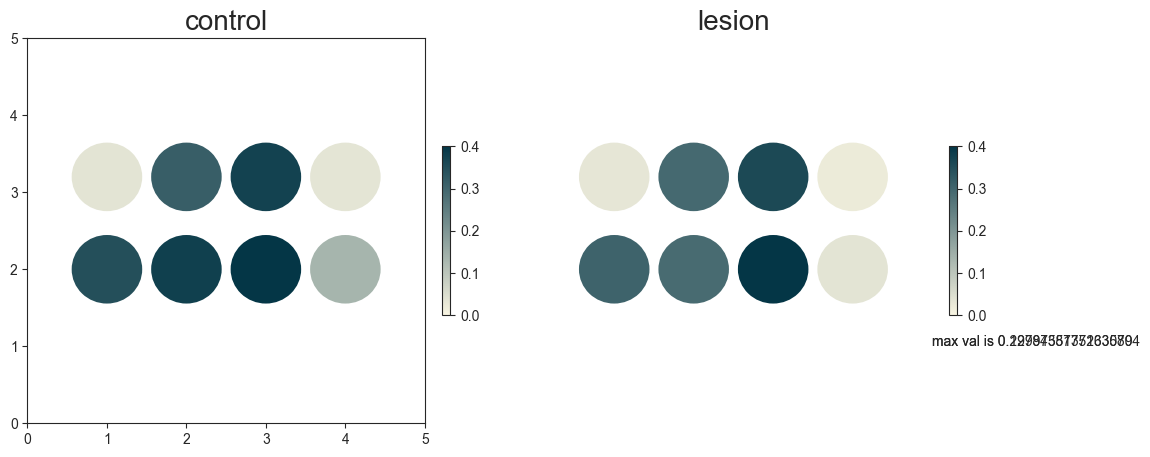

In [174]:
def print_mean_sem(poke_df, var_str):
    poke_df= poke_df[poke_df.group == var_str]

    SEM = [scipy.stats.sem(poke_df.p1),scipy.stats.sem(poke_df.p2),scipy.stats.sem(poke_df.p3),scipy.stats.sem(poke_df.p4),
                scipy.stats.sem(poke_df.p5),scipy.stats.sem(poke_df.p6),scipy.stats.sem(poke_df.p7),scipy.stats.sem(poke_df.p8)]
    MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
                    np.mean(poke_df[mask].p5),np.mean(poke_df[mask].p6),np.mean(poke_df[mask].p7),np.mean(poke_df[mask].p8)]

    print('mean ratios per port: ' + str(np.array(MEAN)*100))
    print('SEM per port: ' + str(np.array(SEM)*100))

## for each session pull out all the first ports that was entered, for the last transiton also take the second one as it wont appear in a subsequent transition
AA_port_proportions= []

for animal in range(len(data.animal.values)):
    ports= []
    for session in np.unique(data.trials_0_1000_session[animal]):
        session_mask = np.array(data.trials_0_1000_session[animal]) == session
        for index, transit in enumerate(np.array(data.trials_0_1000_transitions[animal])[session_mask]):
            ports = ports + [int(str(transit)[0])]
            if index == len(np.array(data.trials_0_1000_transitions[animal])[session_mask])-1:
                ports = ports + [int(str(transit)[-1])]

    port_proportions=[data.group[animal],data.animal.values[animal]]
    for i in range(1,9):
        port_proportions = port_proportions + [sum(np.array(ports) == i)/len(ports)]

    AA_port_proportions = AA_port_proportions + [port_proportions]

poke_proportions_df = pd.DataFrame(AA_port_proportions, columns = ['group','animal','p1','p2','p3','p4','p5','p6','p7','p8'])

masks = [poke_proportions_df.group == 'control',poke_proportions_df.group == 'lesions']

nrow = 1 
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(12, 5))
for ind, ax in enumerate(fig.axes):
    
    mask = masks[ind]

    ax.set_ylim([0, 5])
    ax.set_xlim([0, 5])

    # colormap = plt.cm.get_cmap('YlGnBu') # 'plasma' or 'viridis'
    colormap = cmap

    color_vals = [np.mean(poke_proportions_df[mask].p1),np.mean(poke_proportions_df[mask].p2),np.mean(poke_proportions_df[mask].p3),np.mean(poke_proportions_df[mask].p4),
                  np.mean(poke_proportions_df[mask].p5),np.mean(poke_proportions_df[mask].p6),np.mean(poke_proportions_df[mask].p7),np.mean(poke_proportions_df[mask].p8)]

    normalised_colour = np.array(color_vals)/max(color_vals)

    x = [1,2,3,4,1,2,3,4]
    y = [2,2,2,2,3.2,3.2,3.2,3.2]

    circles_ = []
    for i in range(8):
        color_ = colormap(normalised_colour[i])
        circles_ = circles_ + [plt.Circle((x[i], y[i]), 0.4,fill=True, linewidth=5, color = color_)]
    for i in range(8):
        ax.add_artist(circles_[i])

    plt.axis('off')
    ax.set_title(['control', 'lesion'][ind], size=20)

    # sc = plt.scatter(x, y, c=colors)

    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=0.4)
    plt.text(5,1,('max val is '+ str(max(color_vals))),size=10)

    plt.colorbar(sm,fraction=0.02, pad=0.04,ax = ax)
    

print_mean_sem(poke_proportions_df, 'lesions')
print_mean_sem(poke_proportions_df, 'control')

# SaveFig('hlesion_port-poke-proportions-1st-1000.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_port-poke-proportions-1st-1000.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

In [175]:
print_mean_sem(poke_proportions_df, 'control')


mean ratios per port: [nan nan nan nan nan nan nan nan]
SEM per port: [0.77462855 1.26432704 1.18203846 4.01533484 0.40373948 0.83521184
 1.75137658 0.15954047]


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_30128\4270542205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  MEAN = [np.mean(poke_df[mask].p1),np.mean

In [176]:
mask = poke_proportions_df. group == 'control'

In [177]:
poke_df= poke_proportions_df

MEAN = [np.mean(poke_df[mask].p1),np.mean(poke_df[mask].p2),np.mean(poke_df[mask].p3),np.mean(poke_df[mask].p4),
                np.mean(poke_df[mask].p5),np.mean(poke_df[mask].p6),np.mean(poke_df[mask].p7),np.mean(poke_df[mask].p8)]


poke port relevance over time - how often do they poke into irrelevant ports

# port / port transition times - 1st 1000 trials 

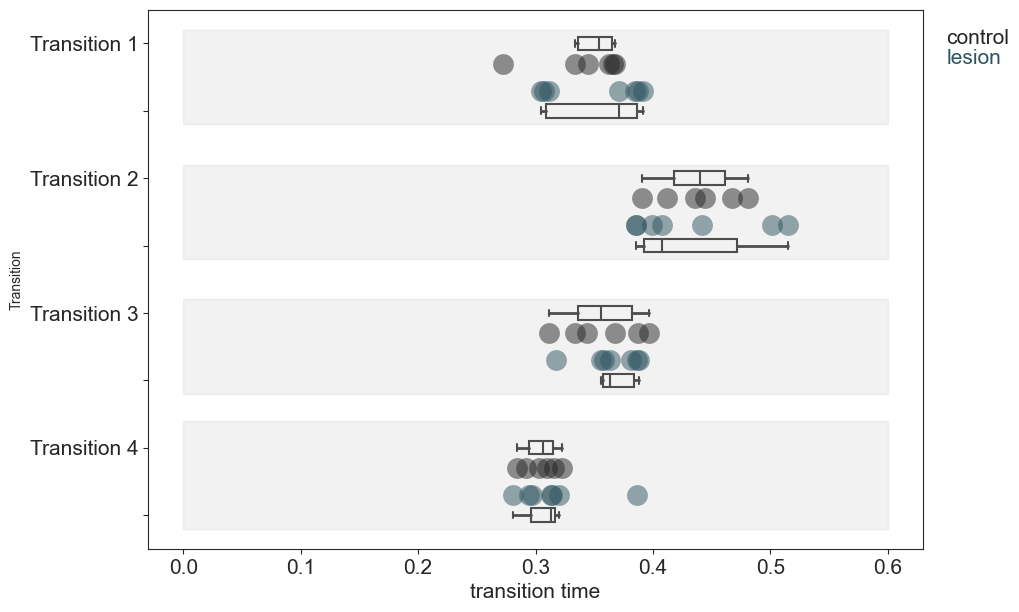

In [178]:
import statistics
import seaborn as sns
sns.set_style("ticks")
masks = [data.group == 'control',data.group == 'lesions']

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(10, 7))
for ind, ax in enumerate(fig.axes):
    sns.axes_style()
    
    plot_df = pd.DataFrame({'mouse':[],'group':[],'Transition':[],'Time':[]})
    plot2_df = pd.DataFrame({'mouse':[],'group':[],'Transition':[],'sdevs':[]})
    
    for ind in range (2):

        mask = masks[ind]
        Transitions = [21,16,63,37]

        for _, row in data[mask].iterrows():

            #pull data from dfs:
            TransitionTypes_unfilt = np.array(row.trials_0_1000_transitions)
            TransitionLatency_unfilt = np.array(row.trials_0_1000_latency)

            # filter out transitions that are too slow (defined in preprocessing as 2s) and filter out transitions that are too fast (negative - this is probably a hardware error)   
            filter_mask = (np.array(TransitionLatency_unfilt) > 0) * (np.array(TransitionLatency_unfilt) < 2)
            TransitionTypes_Tfilt  = TransitionTypes_unfilt[filter_mask]
            TransitionLatency_Tfilt  = TransitionLatency_unfilt[filter_mask]

            Transition_Latencies, transition_type = Find_Transition_times_sns(TransitionLatency_Tfilt,TransitionTypes_Tfilt,Transitions)
            if transition_type: #if its not empty
                df = pd.DataFrame({'Transition' : transition_type,'Time':Transition_Latencies})
            sdevs = [statistics.stdev(df.Time[df.Transition.values == 1]),statistics.stdev(df.Time[df.Transition.values == 2]),statistics.stdev(df.Time[df.Transition.values == 3]),statistics.stdev(df.Time[df.Transition.values == 4])]
            means = [np.mean(df.Time[df.Transition.values == 1]),np.mean(df.Time[df.Transition.values == 2]),np.mean(df.Time[df.Transition.values == 3]),np.mean(df.Time[df.Transition.values == 4])]
            t_code = [[0,2,4,6],[1,3,5,7]]
            tempt_df = pd.DataFrame({'mouse':[_]*len(sdevs) , 'group':[row.group]*len(sdevs),'Transition':t_code[ind],'Time':means})
            plot_df = pd.concat([plot_df, tempt_df])
            
            sdevs = [statistics.stdev(df.Time[df.Transition.values == 1]),statistics.stdev(df.Time[df.Transition.values == 2]),statistics.stdev(df.Time[df.Transition.values == 3]),statistics.stdev(df.Time[df.Transition.values == 4])]
            t_code = [[0,2,4,6],[1,3,5,7]]
            tempt_df = pd.DataFrame({'mouse':[_]*len(sdevs) , 'group':[row.group]*len(sdevs),'Transition':t_code[ind],'sdevs':sdevs})
            plot2_df = pd.concat([plot2_df, tempt_df])

        ### 
    

    for i in range(8):
        x = np.ones(len(plot_df.Time[plot_df.Transition == i])) *[0.3, 0.7,2.3,2.7,4.3,4.7,6.3,6.7][i]
        if i%2 == 0:
            color = '#252525'
        else:
            color = '#2D5460'
        ax.plot(plot_df.Time[plot_df.Transition == i],x,'o',markersize = 15,markeredgewidth = 0, c = color, alpha = 0.5)
    

    ax=sns.boxplot (x = 'Time', y = 'Transition', data = plot_df, color = 'grey', width = .2, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                   saturation = 1, orient = 'h',ax = ax)

    ax.set_xlabel('transition time',size = 15)

    ax.tick_params(axis="x", labelsize=15)
    
    ax.text(0.65,0,'control',size=15, color = '#252525')
    ax.text(0.65,0.3,'lesion',size=15,color = '#2D5460')
    
#     ax.fill_between(0,1,1,
#     alpha=0.2, edgecolor='None', facecolor='#BE575F',
#     linewidth=1, linestyle='dashdot', antialiased=True)
    
    plt.fill_betweenx([-0.2,1.2], 0, 0.6, color='grey', alpha=.1)
    plt.fill_betweenx([1.8,3.2], 0, 0.6, color='grey', alpha=.1)
    plt.fill_betweenx([3.8,5.2], 0, 0.6, color='grey', alpha=.1)
    plt.fill_betweenx([5.6,7.2], 0, 0.6, color='grey', alpha=.1)
    
    ax.set_yticklabels(['Transition 1','','Transition 2','','Transition 3','','Transition 4','' ], fontsize = 15)
    
# SaveFig('hlesion_transition-times-1st-1000.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_transition-times-1st-1000.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


In [179]:
lesion_times = plot_df[plot_df.group == 'lesions'].Time
control_times = plot_df[plot_df.group == 'control'].Time

one group has a p of less than 0.05 so is not normally distributed
ShapiroResult(statistic=0.7061099208210108, pvalue=0.007164923618571052)
ShapiroResult(statistic=0.8814047574427224, pvalue=0.23275696340199037)
so I use non paramteric comparisions test:
RanksumsResult(statistic=0.42857142857142855, pvalue=0.6682351417952492)


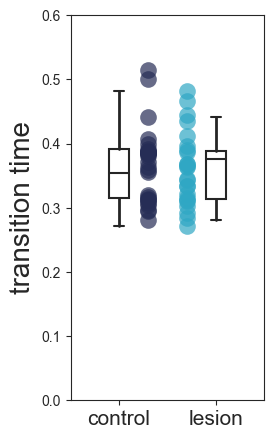

In [180]:
type_ = ['c_error_rate']*len(list(error_rate_df[error_rate_df.group == 'control'].error_rate.values)) + ['l_error_rate']*len(list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values))
scores = list(error_rate_df[error_rate_df.group == 'control'].error_rate.values) + list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values)
plt_df = pd.DataFrame({'group':type_,'score':scores})


fig, ax = plt.subplots(1, 1,figsize=(2.5,5))

color = '#262D56'
x = [0.3] * len(lesion_times)
ax.plot(x, lesion_times,'o',markersize = 12, c = color, alpha = 0.7,markeredgewidth = 0)

color = '#2FA7C4'
x = [0.7] * len(control_times)
ax.plot(x, control_times,'o',markersize = 12, c = color,alpha = 0.7,markeredgewidth = 0)

ax=sns.boxplot( y = 'Time', x = 'group', data = plot_df, color = '#262D56', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_xticklabels(('control', 'lesion'), fontsize = 15)
ax.set_xlabel('',size = 20)
ax.set_ylabel('transition time',size = 20)

ax.set_ylim(0,0.6)

a = error_rate_df[error_rate_df.group == 'control'].error_rate.values
b = error_rate_df[error_rate_df.group == 'lesions'].error_rate.values

print('one group has a p of less than 0.05 so is not normally distributed')
print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
print('so I use non paramteric comparisions test:')
print(scipy.stats.ranksums(a,b))

# SaveFig('hlesion_error-rate-1st-1000.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('mean_overall_transit_time-1st-1000.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


# extract data for across trials plots

In [181]:
def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

AA_e_score = []
AA_c_score = []
AA_n_score = []
AA_transit_times_mean = []
AA_trial_distraction_proportion = []
AA_mean_distraction_time = []
AA_relevant_pokes_prop = []
AA_all_times_distracted = []

group =[]

for _, row in data.iterrows():
    #pull data from dfs:
    TransitionTypes_unfilt = np.array(row.trials_0_1000_transitions)
    TransitionLatency_unfilt = np.array(row.trials_0_1000_latency)

    # Convert session strings to integers and create a mask for session 0
    session_ids = np.array([int(x) for x in np.array(row.trials_0_1000_session).tolist()])
    

    c_score = []
    e_score = []
    n_score = []
    transit_times_mean = []
    
    mouse_distract_prop = []
    mouse_mean_distract_time = []
    mouse_relevant_pokes_prop = []
    mouse_all_times_distracted = []
    for i in range(max(session_ids)+1):
        mask = session_ids == i
        # Filter trial IDs based on the session mask
        trial_ids_current = np.array(row.trials_0_1000_trial_id)[mask]

        # Get unique trial IDs for session 
        unique_trial_ids = np.unique(trial_ids_current)

        # Iterate over each unique trial ID
        trial_distraction_proportion = []
        trial_mean_distraction_time = []
        trial_relevant_pokes_prop = []
        for trial_id in unique_trial_ids:
            # Find indices where the current trial ID matches
            inds = np.where(trial_ids_current == trial_id)[0]
            
            #take all the transitions, filter out those that take too long
            trial_t_types = TransitionTypes_unfilt[mask][inds]
            trial_t_times = TransitionLatency_unfilt[mask][inds]
            # filter by time 
            filter_mask = (np.array(trial_t_times) > 0) * (np.array(trial_t_times) < 2)
            trial_t_types_filt = trial_t_types[filter_mask]
            # find corrects
            if len(trial_t_types_filt) > 0:
                e_score += [determine_seq_scores_and_indicies(list(trial_t_types_filt),Error)[0]/len(trial_t_types_filt)]
                c_score += [determine_seq_scores_and_indicies(list(trial_t_types_filt),Correct)[0]/len(trial_t_types_filt)]
                n_score += [determine_seq_scores_and_indicies(list(trial_t_types_filt),Neutral)[0]/len(trial_t_types_filt)]
            else:
                e_score += [1]
                c_score += [0]
                n_score += [1]
                
            # av transit time for non distracted transits
            if len(trial_t_times[trial_t_times < 2]) > 0:   
                transit_times_mean += [np.mean(trial_t_times[trial_t_times < 2])]
            else:
                transit_times_mean += [np.nan]
            
            ## how many pauses did the mice take - mid trial . distraction index
            trial_distraction_proportion += [len(trial_t_times[trial_t_times > 2])/len(trial_t_times)]
            if len(trial_t_times[trial_t_times > 2]) > 0:
                trial_mean_distraction_time += [np.mean(trial_t_times[trial_t_times > 2])]
                mouse_all_times_distracted += list(trial_t_times[trial_t_times > 2])
            else:
                trial_mean_distraction_time += [np.nan]

            relevant = 0
            irrelevant = 0
            for transit in np.append(trial_t_types,int(str(trial_t_types[-1])[-1])): # this is to include the very last port
                port_poked = int(str(transit)[0])
                if port_poked in [2,1,6,3,7]:
                    relevant+=1
                else:
                    irrelevant+=1
            trial_relevant_pokes_prop += [relevant/(relevant+irrelevant)]
            
        mouse_distract_prop += [trial_distraction_proportion]
        mouse_mean_distract_time += [trial_mean_distraction_time]
        mouse_relevant_pokes_prop += trial_relevant_pokes_prop
                

    AA_e_score += [e_score]
    AA_c_score += [c_score]
    AA_n_score += [n_score]
    AA_transit_times_mean += [transit_times_mean]
    AA_trial_distraction_proportion += [mouse_distract_prop]
    AA_mean_distraction_time += [mouse_mean_distract_time]
    AA_relevant_pokes_prop += [mouse_relevant_pokes_prop]
    AA_all_times_distracted += [mouse_all_times_distracted]
    group += [row.group]
    
 

# port poke relevance across trials 

add in shuffled stats curves for each of these curves 

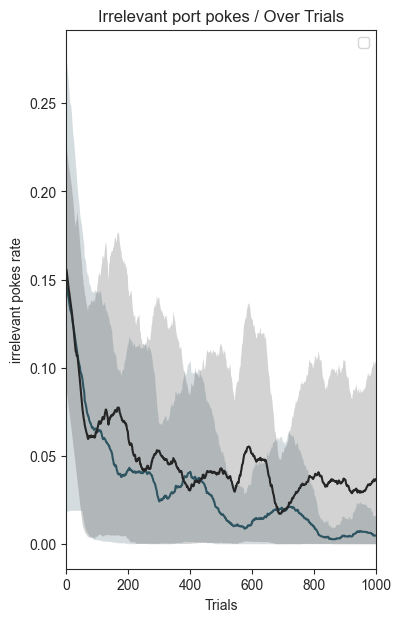

In [233]:
fig, ax = plt.subplots(figsize=(4, 7))

lesi_av = []
cont_av = []
irr_props = []
for i, relevant_prop in enumerate(AA_relevant_pokes_prop):
    irr_prop = 1-np.array(relevant_prop)
    irr_props += [irr_prop]
    if group[i] == 'lesions':
        col = '#2D5460'
        label = 'Lesions' 
        lesi_av += [irr_prop]
    else:
        col = '#252525'
        label = 'Control'
        cont_av += [irr_prop]
        


    # ax.plot(convolve_movmean(irr_prop, 100), c=col, alpha=0.4, label=label)
    
ax.plot(convolve_movmean(np.mean(lesi_av, axis=0),100), c = '#2D5460')

# Ensure all elements in cont_av have the same length
max_length = max(len(item) for item in cont_av)
cont_av_padded = [np.pad(item, (0, max_length - len(item)), 'constant', constant_values=np.nan) for item in cont_av]
# Calculate the mean, ignoring NaNs
mean_cont_av = np.nanmean(cont_av_padded, axis=0)

ax.plot(convolve_movmean(mean_cont_av,100), c = '#252525')


# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_title('Irrelevant port pokes / Over Trials')
xlim= 1000
ax.set_xlim(0, xlim)
ax.set_xlabel('Trials')
ax.set_ylabel('irrelevant pokes rate')

# Calculate mean and std for lesion and control groups
def plot_std_region(ax, lesi_av, xlim, color,convolve_window):
    std_curve = []
    for item in conactinate_nth_items(lesi_av):
        std_curve += [np.nanstd(item)]
    # mean_curve = convolve_movmean(np.mean(lesi_av, axis=0), convolve_window)
    mean_curve = np.nanmean(lesi_av, axis=0)
    upper = np.array(mean_curve[:xlim]) + np.array(std_curve[:xlim])
    lower = np.array(mean_curve[:xlim]) - np.array(std_curve[:xlim])
    lower[lower < 0] = 0  # floor cutoff
    ax.fill_between(range(len(upper)), convolve_movmean(lower, convolve_window), convolve_movmean(upper, convolve_window), alpha=0.2, edgecolor='None', facecolor=color, linewidth=1, linestyle='dashdot', antialiased=True)

plot_std_region(ax, lesi_av, xlim, '#2D5460',100)
plot_std_region(ax, cont_av_padded, xlim, '#252525',100)

# SaveFig('hlesion_irelevant-pokes-over-trials.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_irelevant-pokes-over-trials.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

100%|██████████| 10000/10000 [00:17<00:00, 557.38it/s]


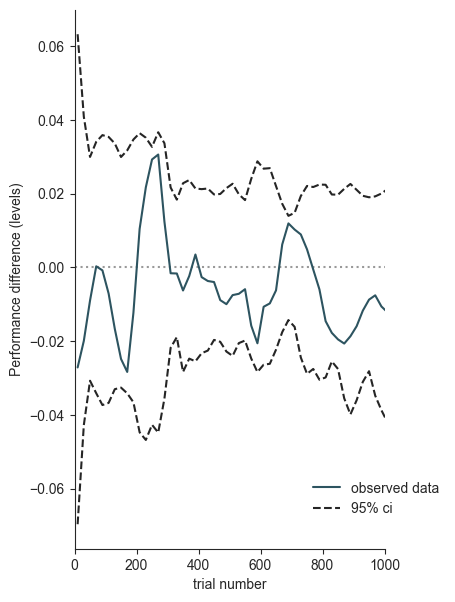

In [234]:
# plot the differences between shuffle and lesion data
cut = 1000
num_shuffles = 10000
bin_size = 20
shuffle_plot_differences([convolve_movmean(item,100) for item in lesi_av],[convolve_movmean(item,100) for item in cont_av_padded] , cut,num_shuffles,bin_size,pl_data.animal.values)
SaveFig('hlesion_irelevant-pokes-over-trials_shuffle.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# error rate over trials

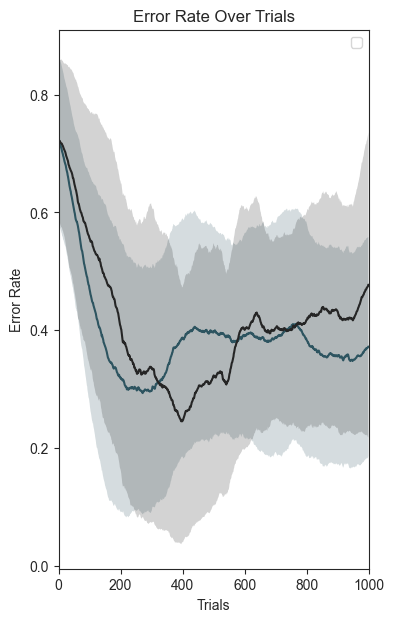

In [235]:

fig, ax = plt.subplots(figsize=(4, 7))

lesi_av = []
cont_av = []
for i, score in enumerate(AA_e_score):
    if group[i] == 'lesions':
        col = 'red'
        label = 'Lesions' 
        lesi_av += [score]
    else:
        col = 'blue'
        label = 'Control'
        cont_av += [score]
    # ax.plot(convolve_movmean(score, 100), c=col, alpha=0.4, label=label)
    
ax.plot(convolve_movmean(np.mean(lesi_av, axis=0),100), c = '#2D5460')

# Ensure all elements in cont_av have the same length
max_length = max(len(item) for item in cont_av)
cont_av_padded = [np.pad(item, (0, max_length - len(item)), 'constant', constant_values=np.nan) for item in cont_av]
# Calculate the mean, ignoring NaNs
mean_cont_av = np.nanmean(cont_av_padded, axis=0)

ax.plot(convolve_movmean(mean_cont_av,100), c = '#252525')


# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

xlim= 1000
ax.set_title('Error Rate Over Trials')
ax.set_xlim(0, xlim)
ax.set_xlabel('Trials')
ax.set_ylabel('Error Rate')

# Calculate mean and std for lesion and control groups
def plot_std_region(ax, lesi_av, xlim, color,convolve_window):
    std_curve = []
    for item in conactinate_nth_items(lesi_av):
        std_curve += [np.nanstd(item)]
    # mean_curve = convolve_movmean(np.mean(lesi_av, axis=0), convolve_window)
    mean_curve = np.nanmean(lesi_av, axis=0)
    upper = np.array(mean_curve[:xlim]) + np.array(std_curve[:xlim])
    lower = np.array(mean_curve[:xlim]) - np.array(std_curve[:xlim])
    lower[lower < 0] = 0  # floor cutoff
    ax.fill_between(range(len(upper)), convolve_movmean(lower, convolve_window), convolve_movmean(upper, convolve_window), alpha=0.2, edgecolor='None', facecolor=color, linewidth=1, linestyle='dashdot', antialiased=True)

plot_std_region(ax, lesi_av, xlim, '#2D5460',100)
plot_std_region(ax, cont_av_padded, xlim, '#252525',100)

# SaveFig('hlesion_error-rate-over-trials.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")


SaveFig('hlesion_error-rate-over-trials.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

100%|██████████| 10000/10000 [01:01<00:00, 163.75it/s]


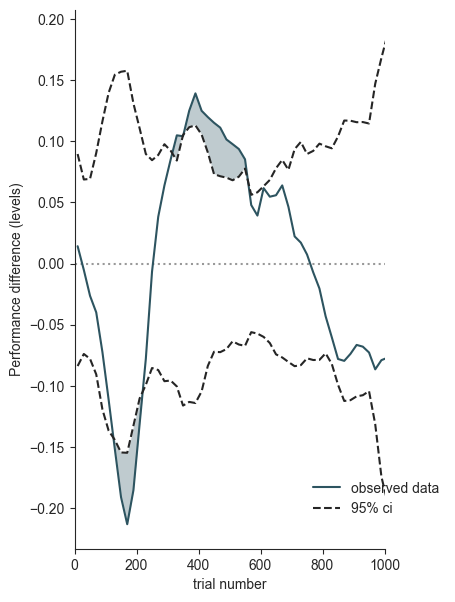

In [236]:
# plot the differences between shuffle and lesion data
cut = 1000
num_shuffles = 10000
bin_size = 20
shuffle_plot_differences([convolve_movmean(item,100) for item in lesi_av],[convolve_movmean(item,100) for item in cont_av_padded] , cut,num_shuffles,bin_size,pl_data.animal.values)
SaveFig('hlesion_error-rate-over-trials_shuffle.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# transit times over trials

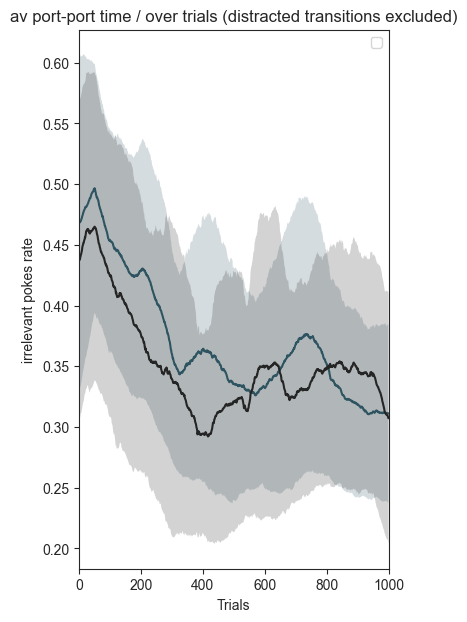

In [237]:
fig, ax = plt.subplots(figsize=(4, 7))

lesi_av = []
cont_av = []

for i, times in enumerate(AA_transit_times_mean):
    if group[i] == 'lesions':
        col = '#2D5460'
        label = 'Lesions' 
        lesi_av += [times]
    else:
        col = '#252525'
        label = 'Control'
        cont_av += [times]
    # ax.plot(convolve_movmean(times, 20), c=col, alpha=0.1, label=label)
        

# Ensure all elements in lesi_av have the same length
max_length = max(len(item) for item in lesi_av)
lesi_av_padded = [np.pad(item, (0, max_length - len(item)), 'constant', constant_values=np.nan) for item in lesi_av]
# Calculate the mean, ignoring NaNs
mean_lesi_av = np.nanmean(lesi_av_padded, axis=0)

ax.plot(convolve_movmean(mean_lesi_av, 100), c = '#2D5460')

# Ensure all elements in cont_av have the same length
max_length = max(len(item) for item in cont_av)
cont_av_padded = [np.pad(item, (0, max_length - len(item)), 'constant', constant_values=np.nan) for item in cont_av]
# Calculate the mean, ignoring NaNs
mean_cont_av = np.nanmean(cont_av_padded, axis=0)

ax.plot(convolve_movmean(mean_cont_av,100), c = '#252525')

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_title('av port-port time / over trials (distracted transitions excluded)')
xlim= 1000
ax.set_xlim(0, xlim)
ax.set_xlabel('Trials')
ax.set_ylabel('irrelevant pokes rate')

plot_std_region(ax, lesi_av_padded, xlim, '#2D5460',100)
plot_std_region(ax, cont_av_padded, xlim, '#252525',100)

# SaveFig('hlesion_transit-times-over-trials.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_transit-times-over-trials.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

100%|██████████| 10000/10000 [00:37<00:00, 268.08it/s]


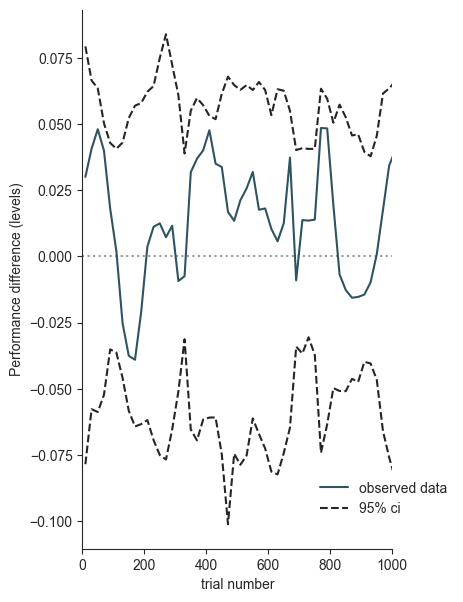

In [238]:
# plot the differences between shuffle and lesion data
cut = 1000
num_shuffles = 10000
bin_size = 20
shuffle_plot_differences([convolve_movmean(item,100) for item in lesi_av],[convolve_movmean(item,100) for item in cont_av_padded] , cut,num_shuffles,bin_size,pl_data.animal.values)
SaveFig('hlesion_transit-times-over-trials_shuffle.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

In [239]:
## distraction index... average over 1000 trials and across trials
## average time distracted over 1000 trials and across trials
## plots for warped sessions to show whether this is just because of the late session stuff? 

# distraction index (how often the mice were distracted over first 1000 trials)


no group has a p of less than 0.05 so they are normally distributed
ShapiroResult(statistic=0.9169497699103448, pvalue=0.4460745601589504)
ShapiroResult(statistic=0.9758510382353524, pvalue=0.9291743251520718)
so I use paramteric comparisions test:
TtestResult(statistic=-5.503189881632835, pvalue=0.00018534424566028112, df=11.0)


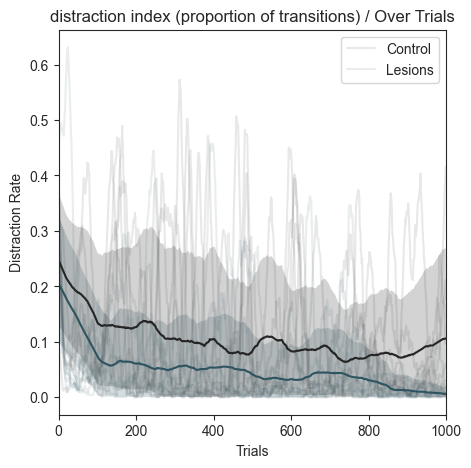

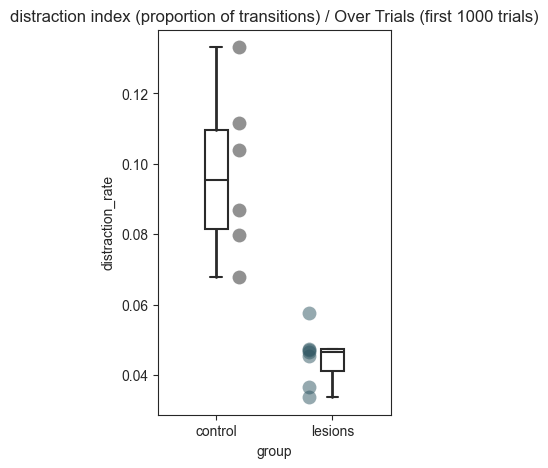

In [267]:

fig, ax = plt.subplots(figsize=(5, 5))

lesi_av = []
cont_av = []
for i,mouse in enumerate(AA_trial_distraction_proportion):
    all_trials = []
    for session in mouse:
        all_trials+=session
        
    if group[i] == 'lesions':
        col = '#2D5460'
        label = 'Lesions' 
        lesi_av += [all_trials]
    else:
        col = '#252525'
        label = 'Control'
        cont_av += [all_trials]
        
    ax.plot(convolve_movmean(all_trials,20), c = col, alpha = 0.1, label = label)


ax.plot(convolve_movmean(np.mean(lesi_av, axis=0),200), c = '#2D5460')

# Ensure all elements in cont_av have the same length
max_length = max(len(item) for item in cont_av)
cont_av_padded = [np.pad(item, (0, max_length - len(item)), 'constant', constant_values=np.nan) for item in cont_av]
# Calculate the mean, ignoring NaNs
mean_cont_av = np.nanmean(cont_av_padded, axis=0)

ax.plot(convolve_movmean(mean_cont_av,200), c = '#252525')


# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

xlim = 1000
ax.set_title('distraction index (proportion of transitions) / Over Trials')
ax.set_xlim(0, xlim)
ax.set_xlabel('Trials')
ax.set_ylabel('Distraction Rate')


plot_std_region(ax, lesi_av, xlim, '#2D5460',200)
plot_std_region(ax, cont_av_padded, xlim, '#252525',200)

SaveFig('hlesion_distraction-index-over-trials.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

##########################

fig, ax = plt.subplots(figsize=(3, 5))

l_means = []
for item in lesi_av:
    l_means += [np.mean(item)]
c_means = []
for item in cont_av:
    c_means += [np.mean(item)]
    
plt.plot(len(l_means) * [0.8], l_means, 'o', c = '#2D5460', alpha = 0.5, markeredgewidth = 0, markersize = 10)
plt.plot(len(c_means) * [0.2], c_means, 'o', c = '#252525', alpha = 0.5, markeredgewidth = 0, markersize = 10)

plt_df = pd.DataFrame({'group':group,'distraction_rate': c_means+l_means})
ax=sns.boxplot( y = 'distraction_rate', x = 'group', data = plt_df, color = '#2D5460', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
ax.set_title('distraction index (proportion of transitions) / Over Trials (first 1000 trials)')

print('no group has a p of less than 0.05 so they are normally distributed')
print(scipy.stats.shapiro(l_means))
print(scipy.stats.shapiro(c_means))
print('so I use paramteric comparisions test:')
print(scipy.stats.ttest_ind(l_means,c_means))

# SaveFig('hlesion_distraction-rate-1st-1000.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_distraction-rate-1st-1000.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# distraction length 

no group has a p of less than 0.05 so they are normally distributed
ShapiroResult(statistic=0.7555427780154711, pvalue=0.01449236920502948)
ShapiroResult(statistic=0.9527389149410267, pvalue=0.7623936451429115)
so I use paramteric comparisions test:
TtestResult(statistic=-2.102265107844501, pvalue=0.059367023152242335, df=11.0)


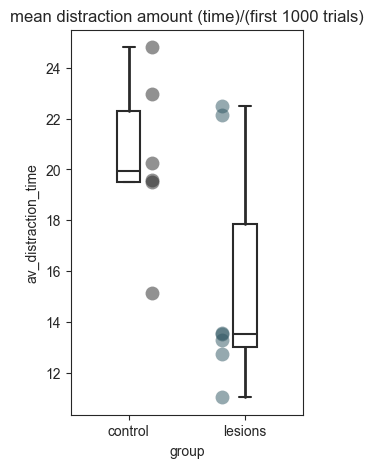

In [270]:
fig, ax = plt.subplots(figsize=(3, 5))

l_means = []
c_means = []
for i,item in enumerate(AA_all_times_distracted):
    if group[i] == 'lesions':
        l_means += [np.mean(item)]
    else:
        c_means += [np.mean(item)]

plt.plot(len(l_means) * [0.8], l_means, 'o', c = '#2D5460', alpha = 0.5, markeredgewidth = 0, markersize = 10)
plt.plot(len(c_means) * [0.2], c_means, 'o', c = '#252525', alpha = 0.5, markeredgewidth = 0, markersize = 10)

plt_df = pd.DataFrame({'group':group,'av_distraction_time': c_means+l_means})
ax=sns.boxplot( y = 'av_distraction_time', x = 'group', data = plt_df, color = '#2D5460', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
ax.set_title('mean distraction amount (time)/(first 1000 trials)')

print('no group has a p of less than 0.05 so they are normally distributed')
print(scipy.stats.shapiro(l_means))
print(scipy.stats.shapiro(c_means))
print('so I use paramteric comparisions test:')
print(scipy.stats.ttest_ind(l_means,c_means))

# SaveFig('hlesion_distraction-time-length-1st-1000.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

SaveFig('hlesion_distraction-rate-1st-1000.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")


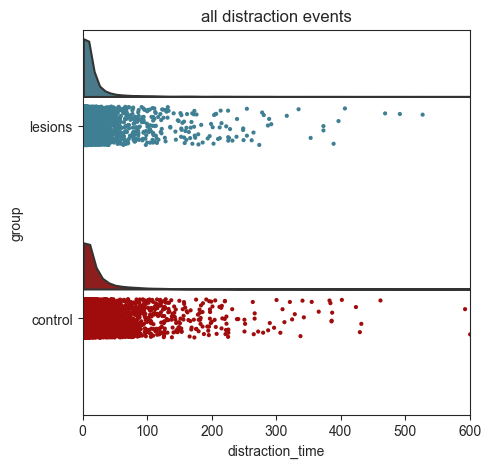

In [262]:
import ptitprince as pt

l_ = []
c_ = []
for i,item in enumerate(AA_all_times_distracted):
    if group[i] == 'lesions':
        l_+= [item]
    else:
        c_ += [item]
    
# Flatten the lists
l_flat = [item for sublist in l_ for item in sublist]
c_flat = [item for sublist in c_ for item in sublist]

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(5, 5))



df = pd.DataFrame({'group': ['lesions']*len(l_flat) + ['control']*len(c_flat), 'distraction_time': l_flat + c_flat})

# ax=pt.half_violinplot( x = 'group', y = 'distraction_time', data = df, bw = .2, cut = 0.,
#                       scale = "area", width = .6, inner = None)

ax=pt.half_violinplot(y = 'group', x = 'distraction_time', data = df, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = 'h')
ax=sns.stripplot( y = 'group', x = 'distraction_time', data = df, edgecolor = "white",
                 size = 3, jitter = 1, zorder = 0, orient = 'h')

ax.set_xlim(0,600)

ax.set_title('all distraction events')

SaveFig('hlesion_distraction-event-lengths.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\\")

# restriction control - weights over time

In [263]:
# load in mouse weight data
h_lesion_weights = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\h_lesion_weights.csv")

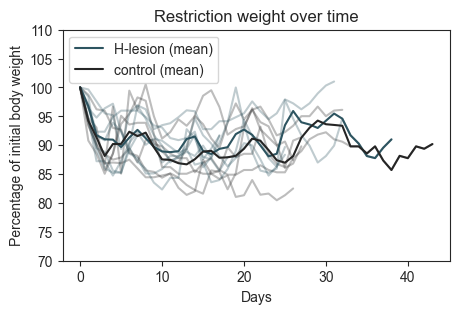

In [264]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

l_ = []
c_ = []
for df in h_lesion_weights.groupby('mouse'):
    type = data.group[np.where(data.animal == df[0])[0][0]]
    prcnts = df[1].percentage.values.astype(float)
    if type == 'lesions':
        col = '#2D5460'
        label = 'H-lesion'
        l_ += [prcnts]
    else:
        col = '#252525'
        label = 'control'
        c_ += [prcnts]
    
    ax.plot(prcnts, c = col, alpha = 0.3)

# Plot the mean lines with labels
l_mean = []
for item in conactinate_nth_items(l_):
    l_mean+=[np.mean(item)]
ax.plot(l_mean, c = '#2D5460',label='H-lesion (mean)')

c_mean = []
for item in conactinate_nth_items(c_):
    c_mean+=[np.mean(item)]
ax.plot(c_mean, c = '#252525',label='control (mean)')


ax.set_ylabel('Percentage of initial body weight')
ax.set_xlabel('Days')
ax.set_title('Restriction weight over time')
ax.set_ylim(70, 110)
ax.legend()

# SaveFig('hlesion-restriction-control-body-weight-over-days.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\h_lesion\\")

SaveFig('hlesion-restriction-control-body-weight-over-days.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

no group has a p of less than 0.05 so they are normally distributed
ShapiroResult(statistic=0.8314744530215642, pvalue=0.08263290107720662)
ShapiroResult(statistic=0.9721966554456826, pvalue=0.9068523389094262)
so I use paramteric comparisions test:
TtestResult(statistic=0.7979088054670177, pvalue=0.44180844810900965, df=11.0)


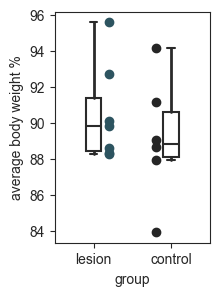

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3))

l_means = list(np.mean(item[3::]) for item in l_)
c_means = list(np.mean(item[3::]) for item in c_)
ax.plot([0.2]*len(l_means),l_means,'o',c = '#2D5460')
ax.plot([0.8]*len(c_means),c_means,'o',c = '#252525')

plt_df = pd.DataFrame({'group':['lesion']*len(l_means) + ['control']*len(c_means),'average body weight %': l_means+c_means})
ax=sns.boxplot( y = 'average body weight %', x = 'group', data = plt_df, color = '#2D5460', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)


print('no group has a p of less than 0.05 so they are normally distributed')
print(scipy.stats.shapiro(l_means))
print(scipy.stats.shapiro(c_means))
print('so I use paramteric comparisions test:')
print(scipy.stats.ttest_ind(l_means,c_means))

# SaveFig('hlesion-restriction-control-body-weight-average.pdf',r"Z:\projects\sequence_squad\revision_data\emmett_revisions\phase1_plots\h_lesion\\")

SaveFig('hlesion-restriction-control-body-weight-average.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

In [266]:
df[0]

'EJT263'

In [84]:
h_lesion_weights.mouse.unique()

array(['EJT187', 'EJT191', 'EJT213', 'EJT214', 'EJT227', 'EJT228',
       'EJT248', 'EJT249', 'EJT250', 'EJT251', 'EJT255', 'EJT256',
       'EJT263'], dtype=object)

In [81]:
data

,group,animal,training_level_by_trial,trials_per_session
0,control,EJT187,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[53, 102, 60, 64, 69, 146, 123, 163, 209, 68, ..."
1,control,EJT191,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[74, 113, 127, 120, 124, 272, 354, 422, 480, 6..."
2,control,EJT213,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[66, 85, 23, 63, 134, 97, 141, 205, 309, 325, ..."
3,control,EJT214,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[86, 65, 70, 119, 143, 270, 256, 276, 274, 186..."
4,control,EJT227,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[40, 26, 28, 91, 3, 3, 59, 55, 198, 117, 142, ..."
5,control,EJT228,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[17, 69, 80, 92, 66, 71, 95, 132, 244, 79, 198..."
6,lesions,EJT248,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[90, 5, 136, 293, 236, 426, 401, 382, 393, 526..."
7,lesions,EJT249,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[111, 4, 139, 317, 127, 282, 623, 401]"
8,lesions,EJT250,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[141, 213, 294, 468, 647, 664, 347, 502, 687, ..."
9,lesions,EJT255,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[100, 154, 500, 534, 440, 401, 375, 505, 639, ..."


In [53]:
from ast import literal_eval
literal_eval(df[1].percentage.values)

ValueError: malformed node or string: array(['100', '94.69', '93.06', '85.71', '88.57', '95.1', '93.59',
       '93.88', '93.88', '90.2', '89.8', '88.57', '87.76', '87.76',
       '85.31', '86.94', '87.76', '85.71', '84.9', '84.9', '85.71',
       '85.71', '86.53', '85.71', '85.31', '85.31', '87.76', '88.98',
       '91.02', '91.84', '92.24', '91.02', '90.61', '89.8', '89.8',
       '88.57', '89.8', '87.35', '85.71', '88.16', '87.76', '89.8',
       '89.39', '90.2'], dtype=object)

array([100.  ,  94.69,  93.06,  85.71,  88.57,  95.1 ,  93.59,  93.88,
        93.88,  90.2 ,  89.8 ,  88.57,  87.76,  87.76,  85.31,  86.94,
        87.76,  85.71,  84.9 ,  84.9 ,  85.71,  85.71,  86.53,  85.71,
        85.31,  85.31,  87.76,  88.98,  91.02,  91.84,  92.24,  91.02,
        90.61,  89.8 ,  89.8 ,  88.57,  89.8 ,  87.35,  85.71,  88.16,
        87.76,  89.8 ,  89.39,  90.2 ])

# recycling: 

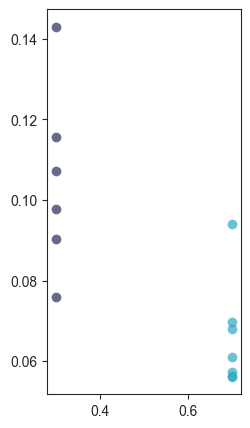

In [264]:
break_rate_df = pd.DataFrame({'animal':[],'group':[],'proportion_breaks':[],'av_break_time':[]})
for _, row in data.iterrows():
    #pull data from dfs:
    TransitionLatency_unfilt = np.array(row.trials_0_1000_latency)
    total = [len(TransitionLatency_unfilt[TransitionLatency_unfilt > 2])/len(TransitionLatency_unfilt)]
    av_break_time = [np.mean(TransitionLatency_unfilt[TransitionLatency_unfilt > 2])]
    
    tempt_df = pd.DataFrame({'animal':[row.animal],'group':[row.group],'proportion_breaks':total,'av_break_time':av_break_time})
    break_rate_df = pd.concat([break_rate_df, tempt_df], ignore_index=True)

# type_ = ['c_error_rate']*len(list(error_rate_df[error_rate_df.group == 'control'].error_rate.values)) + ['l_error_rate']*len(list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values))
# scores = list(error_rate_df[error_rate_df.group == 'control'].error_rate.values) + list(error_rate_df[error_rate_df.group == 'lesions'].error_rate.values)
# plt_df = pd.DataFrame({'group':type_,'score':scores})


fig, ax = plt.subplots(1, 1,figsize=(2.5,5))

color = '#262D56'
x = [0.3] *6
ax.plot(x, break_rate_df[break_rate_df.group == 'control'].proportion_breaks.values,'o',markersize = 7, c = color, alpha = 0.7,markeredgewidth = 0)

color = '#2FA7C4'
x = [0.7] *7
ax.plot(x, break_rate_df[break_rate_df.group == 'lesions'].proportion_breaks.values,'o',markersize = 7, c = color,alpha = 0.7,markeredgewidth = 0)


# ax=sns.boxplot( y = 'score', x = 'group', data = plt_df, color = dark_blue, width = .2, zorder = 10,\
#             showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
#             showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
#                saturation = 1, orient = 'v',ax = ax)

# ax.set_xticklabels(('control', 'lesion'), fontsize = 15)
# ax.set_xlabel('',size = 20)
# ax.set_ylabel('error rate',size = 20)

# ax.set_ylim(0,1)

# a = error_rate_df[error_rate_df.group == 'control'].error_rate.values
# b = error_rate_df[error_rate_df.group == 'lesions'].error_rate.values

# print('one group has a p of less than 0.05 so is not normally distributed')
# print(scipy.stats.shapiro(a))
# print(scipy.stats.shapiro(b))
# print('so I use non paramteric comparisions test:')
# print(scipy.stats.ranksums(a,b))

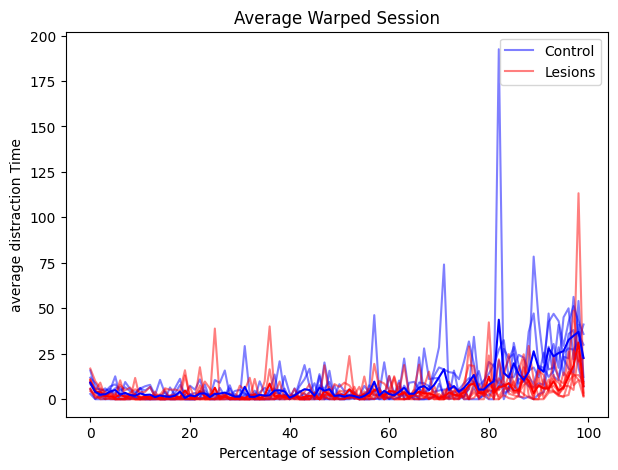

In [634]:
import numpy as np

import matplotlib.pyplot as plt
def warp_to_fixed_length(session_data, target_length=100):
    """
    Warp the session data to a fixed length using interpolation.
    
    Parameters:
    trial_data (list): List of data points for a trial.
    target_length (int): The desired length of the output data.
    
    Returns:
    np.ndarray: Warped data with the specified length.
    """
    original_length = len(session_data)
    original_indices = np.linspace(0, 1, original_length)
    target_indices = np.linspace(0, 1, target_length)
    warped_data = np.interp(target_indices, original_indices, session_data)
    return warped_data

AA_average_warped_session= []
for i in range(len(AA_mean_distraction_time)): 
    # warp the trials to a fixed length of 100, but only if there are at least 100 trials in the session 
    warped_trials = [warp_to_fixed_length(session_, 100) for session_ in AA_mean_distraction_time[i] if len(session_) > 100]

    # Calculate the average warped session
    average_warped_session = np.mean(warped_trials, axis=0)
    AA_average_warped_session += [average_warped_session]

# Plot the average warped session
fig, ax = plt.subplots(1, 1,figsize=(7,5))

lesi_av = []
cont_av = []
for i, average_warp in enumerate(AA_average_warped_session):
    if group[i] == 'lesions':
        col = 'red'
        label = 'Lesions' 
        lesi_av += [average_warp]
    else:
        col = 'blue'
        label = 'Control'
        cont_av += [average_warp]
    ax.plot(average_warp, c = col, alpha = 0.5, label = label)
    
ax.plot(np.mean(lesi_av, axis=0), c = 'red')
ax.plot(np.mean(cont_av, axis=0), c = 'blue')

ax.set_xlabel('Percentage of session Completion')
ax.set_ylabel('average distraction Time')
ax.set_title('Average Warped Session')

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())



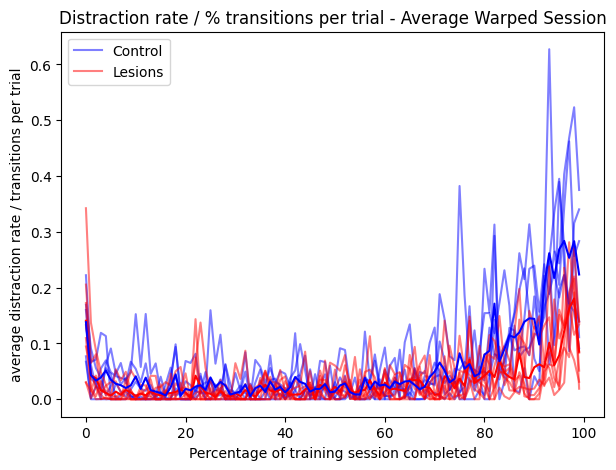

In [639]:


AA_average_warped_session= []
for i in range(len(AA_trial_distraction_proportion)):
    # warp the trials to a fixed length of 100, but only if there are at least 100 trials in the session 
    warped_trials = [warp_to_fixed_length(session_, 100) for session_ in AA_trial_distraction_proportion[i] if len(session_) > 100]
    
    # Calculate the average warped session
    average_warped_session = np.mean(warped_trials, axis=0)
    AA_average_warped_session += [average_warped_session]

# Plot the average warped session
fig, ax = plt.subplots(1, 1,figsize=(7,5))

lesi_av = []
cont_av = []
for i, average_warp in enumerate(AA_average_warped_session):
    if group[i] == 'lesions':
        col = 'red'
        label = 'Lesions' 
        lesi_av += [average_warp]
    else:
        col = 'blue'
        label = 'Control'
        cont_av += [average_warp]
    ax.plot(average_warp, c = col, alpha = 0.5, label = label)
    
ax.plot(np.mean(lesi_av, axis=0), c = 'red')
ax.plot(np.mean(cont_av, axis=0), c = 'blue')

plt.xlabel('Percentage of training session completed')
plt.ylabel('average distraction rate / transitions per trial')
plt.title('Distraction rate / % transitions per trial - Average Warped Session')    

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())


